In [2]:
import numpy as np
import pandas as pd

In [76]:

import math
from typing import List, Dict, Tuple, Union
import torch 

BBox = Union[Dict[str, float], Dict[str, int], Tuple[float, float, float, float], List[float]]

def _coerce_bbox(b: BBox) -> Tuple[float, float, float, float]:
    if isinstance(b, (list, tuple)) and len(b) == 4:
        return float(b[0]), float(b[1]), float(b[2]), float(b[3])
    if isinstance(b, dict):
        keys = {k.lower(): k for k in b.keys()}
        def g(k):
            for cand in (k, k.replace('main', 'min')):  # tolerate 'ymain' -> 'ymin'
                if cand in keys:
                    return float(b[keys[cand]])
            raise KeyError(f"Missing key {k} in bbox dict: {b}")
        return g('xmin'), g('ymin'), g('xmax'), g('ymax')
    raise TypeError(f"Unsupported bbox format: {type(b)}")

def bbox_patch_binary_masks(
    image_w: int,
    image_h: int,
    bboxes: Union[BBox, List[BBox]],
    patch_w: int = 14,
    patch_h: int = None,
    *,
    inclusive_xymax: bool = False
) -> List[List[int]]:
    """
    For a W×H image split into patch_w×patch_h patches (row-major),
    return, for each bbox, a flat 0/1 list of length (num_rows*num_cols)
    marking patches that intersect the bbox.

    Args:
        image_w, image_h: image size in pixels (e.g., 336, 336)
        bboxes: single bbox or list of bboxes. Each bbox can be:
                - dict with keys xmin,ymin,xmax,ymax (case-insensitive; 'ymain' tolerated)
                - list/tuple [xmin, ymin, xmax, ymax]
        patch_w, patch_h: patch size in pixels (default 14×14). If patch_h is None, uses patch_w.
        inclusive_xymax: treat (xmax,ymax) as inclusive if True; exclusive if False.

    Returns:
        List of binary masks (one per bbox). Each mask is a list[int] of length num_rows*num_cols.
        Indexing is row-major: idx = row * num_cols + col.
    """
    if patch_h is None:
        patch_h = patch_w

    num_cols = math.ceil(image_w / patch_w)
    num_rows = math.ceil(image_h / patch_h)
    total_patches = num_rows * num_cols

    # Normalize to list of bboxes
    if isinstance(bboxes, list) and not (len(bboxes) == 4 and all(isinstance(v, (int, float)) for v in bboxes)):
        bbox_list = bboxes
    else:
        bbox_list = [bboxes]

    masks: List[List[int]] = []

    for b in bbox_list:
        x0, y0, x1, y1 = _coerce_bbox(b)
        if inclusive_xymax:
            x1 += 1.0
            y1 += 1.0

        # Clamp to image bounds
        x0 = max(0.0, min(x0, float(image_w)))
        y0 = max(0.0, min(y0, float(image_h)))
        x1 = max(0.0, min(x1, float(image_w)))
        y1 = max(0.0, min(y1, float(image_h)))

        # Degenerate -> all zeros
        if x1 <= x0 or y1 <= y0:
            masks.append([0] * total_patches)
            continue

        # Candidate patch span
        col_start = int(math.floor(x0 / patch_w))
        col_end   = int(math.ceil (x1 / patch_w) - 1)
        row_start = int(math.floor(y0 / patch_h))
        row_end   = int(math.ceil (y1 / patch_h) - 1)

        col_start = max(0, min(col_start, num_cols - 1))
        col_end   = max(0, min(col_end,   num_cols - 1))
        row_start = max(0, min(row_start, num_rows - 1))
        row_end   = max(0, min(row_end,   num_rows - 1))

        mask = [0] * total_patches

        # Mark intersecting patches
        for r in range(row_start, row_end + 1):
            for c in range(col_start, col_end + 1):
                patch_x0 = c * patch_w
                patch_y0 = r * patch_h
                patch_x1 = min(patch_x0 + patch_w, image_w)
                patch_y1 = min(patch_y0 + patch_h, image_h)

                inter_w = max(0.0, min(x1, patch_x1) - max(x0, patch_x0))
                inter_h = max(0.0, min(y1, patch_y1) - max(y0, patch_y0))
                if inter_w > 0.0 and inter_h > 0.0:
                    idx = r * num_cols + c
                    mask[idx] = 1

        masks.append(mask)

    return masks



def combine_mask_tensor(masks: List[List[int]], *, out_dtype=torch.int) -> torch.Tensor:
    if len(masks) == 0:
        return torch.empty((0,), dtype=out_dtype)
    mask_tensor = torch.as_tensor(masks, dtype=out_dtype)
    
    if mask_tensor.numel() == 0:
        # Empty input -> empty output
        return torch.empty((mask_tensor.shape[-1] if mask_tensor.ndim == 2 else 0,), 
                           dtype=out_dtype, device=mask_tensor.device)

    # Normalize to bool
    mask_bool = (mask_tensor != 0) if mask_tensor.dtype != torch.bool else mask_tensor
    # Row-wise OR -> single row
    combined_bool = torch.any(mask_bool, dim=0)
    return combined_bool.to(out_dtype)


In [109]:
masks =  bbox_patch_binary_masks(
    image_w = 336,
    image_h = 336,
    bboxes = [{'xmin': 0, 'ymin': 0, 'xmax': 0, 'ymax': 0}],
    patch_w = 14,
    patch_h = 14
)

In [110]:
combine_mask_tensor(masks)

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [15]:
data = pd.read_csv("/Data2/Arun-UAV/NLP/vision_halu/evidence_head_train_datasets/coco_long_captions/coco_img_des_10k_bb_annot.csv")

In [17]:
data.head(2)

,image_id,question,answer,target_words,image_path
0,COCO_train2014_000000557315.jpg,Please describe this image in detail.,This outdoor scene captures a black bear in wh...,"[{'word': 'black', 'class': 'attribute', 'bbox...",/Data2/Arun-UAV/NLP/vision_halu/train_datasets...
1,COCO_train2014_000000106639.jpg,Please describe this image in detail.,"The image presents an inviting indoor scene, l...","[{'word': 'dining', 'class': 'attribute', 'bbo...",/Data2/Arun-UAV/NLP/vision_halu/train_datasets...


In [50]:
eval(data["target_words"].iloc[100])[3]["bbox"]

[{'xmin': 174, 'ymin': 308, 'xmax': 234, 'ymax': 458},
 {'xmin': 107, 'ymin': 347, 'xmax': 164, 'ymax': 487},
 {'xmin': 276, 'ymin': 268, 'xmax': 303, 'ymax': 305},
 {'xmin': 291, 'ymin': 278, 'xmax': 324, 'ymax': 308}]

In [51]:

boxes = eval(data["target_words"].iloc[100])[3]["bbox"]
masks = bbox_patch_binary_masks(bboxes = boxes, image_w=336, image_h=336, patch_w=14)
combined_from_lists = combine_mask_tensor(masks)


In [53]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class QueryAdapterMLP(nn.Module):
    """
    A3 (richer): 1-hidden MLP for query generation
    LN -> Linear(d -> d/2) -> GELU -> Linear(d/2 -> d_k)

    Inputs:
        h_txt: Tensor of shape [T, d] or [B, T, d]
               Hidden states of text tokens at the tapped layer.

    Outputs:
        q:     Tensor of shape [T, d_k] or [B, T, d_k]
               Query vectors for the Evidence Head scorer.
    """
    def __init__(
        self,
        d: int,
        d_k: int,
        *,
        hidden: int | None = None,
        dropout: float = 0.0,
        ln_eps: float = 1e-5,
        l2_normalize: bool = False,  # set True if you plan cosine scoring
    ):
        super().__init__()
        hidden = hidden or (d // 2)

        self.ln = nn.LayerNorm(d, eps=ln_eps)
        self.fc1 = nn.Linear(d, hidden, bias=True)
        self.act = nn.GELU()
        self.fc2 = nn.Linear(hidden, d_k, bias=True)
        self.dropout = nn.Dropout(dropout)
        self.l2_normalize = l2_normalize


    def forward(self, h_txt: torch.Tensor) -> torch.Tensor:
        # Accept [T, d] or [B, T, d]
        is_batched = (h_txt.dim() == 3)
        if not is_batched:
            h_txt = h_txt.unsqueeze(0)  # -> [1, T, d]

        x = self.ln(h_txt)             # [B, T, d]
        x = self.fc1(x)                # [B, T, hidden]
        x = self.act(x)
        x = self.dropout(x)
        q = self.fc2(x)                # [B, T, d_k]

        if self.l2_normalize:
            q = F.normalize(q, p=2, dim=-1)

        if not is_batched:
            q = q.squeeze(0)           # -> [T, d_k]
        return q

In [58]:
d, hidden, d_k = 1024, 2048, 1024
adapter = QueryAdapterMLP(d=d, d_k=d_k, dropout=0.05, l2_normalize=False)

# Single sequence: [T, d]
T = 64
h_txt = torch.randn(T, d)  # hidden states at tap layer
q = adapter(h_txt)         # [T, d_k]
# print(q.shape)

# # Batched: [B, T, d]
# B = 2
# h_txt_b = torch.randn(B, T, d)
# q_b = adapter(h_txt_b)     # [B, T, d_k]
# print(q_b.shape)


In [59]:
h_txt.shape

torch.Size([64, 1024])

In [60]:
q.shape

torch.Size([64, 1024])

In [75]:
import uuid

In [96]:
path = "/Data2/Arun-UAV/NLP/vision_halu/evidence_head_train_datasets/holoc/downscaled_total_holoc_evidence_head_train_data_60k.csv"
evi_data = pd.read_csv(path)
evi_data.head(2)

,image_id,question,answer,target_words,candidates,image_path,question_id
0,2410010,Question: Where is the pot?,on ground,"[{'word': 'on ground', 'class': 'object', 'bbo...","[{'word': 'on ground', 'class': 'object', 'bbo...",/Data2/Arun-UAV/NLP/vision_halu/visual_genome/...,cc9cdb01-b428-4d5c-a5c9-5c8d265f5af2
1,2401504,Is there a boat visible in the ocean within th...,"Yes, there is a boat in the ocean.","[{'word': 'boat', 'class': 'object', 'bbox': [...","[{'word': 'boat', 'class': 'object', 'bbox': [...",/Data2/Arun-UAV/NLP/vision_halu/visual_genome/...,547d8189-50f5-4c03-bea8-6ef3d22e5cfe


In [94]:
question_ids = [str(uuid.uuid4()) for _ in range(len(evi_data))]
evi_data["question_id"] = question_ids
evi_data = evi_data.rename(columns={"downscale_target_words_bb_info":"candidates"})
evi_data.head(2)

,image_id,question,answer,target_words,candidates,image_path,question_id
0,2410010,Question: Where is the pot?,on ground,"[{'word': 'on ground', 'class': 'object', 'bbo...","[{'word': 'on ground', 'class': 'object', 'bbo...",/Data2/Arun-UAV/NLP/vision_halu/visual_genome/...,cc9cdb01-b428-4d5c-a5c9-5c8d265f5af2
1,2401504,Is there a boat visible in the ocean within th...,"Yes, there is a boat in the ocean.","[{'word': 'boat', 'class': 'object', 'bbox': [...","[{'word': 'boat', 'class': 'object', 'bbox': [...",/Data2/Arun-UAV/NLP/vision_halu/visual_genome/...,547d8189-50f5-4c03-bea8-6ef3d22e5cfe


In [95]:
evi_data.to_csv(path, index=False)

In [2]:
import pandas as pd
det_data =pd.read_csv("/Data2/Arun-UAV/NLP/vision_halu/evidence_head_train_datasets/coco_long_captions/downscaled_total_coco_evidence_head_train_data_15k.csv")

In [3]:
det_data.head(2)

,image_id,question,answer,target_words,image_path,candidates,question_id
0,COCO_train2014_000000557315.jpg,Please describe this image in detail.,This outdoor scene captures a black bear in wh...,"[{'word': 'black', 'class': 'attribute', 'bbox...",/Data2/Arun-UAV/NLP/vision_halu/train_datasets...,"[{'word': 'black', 'class': 'attribute', 'bbox...",8e9ab779-7bae-400d-961a-b6a94df2cd14
1,COCO_train2014_000000106639.jpg,Please describe this image in detail.,"The image presents an inviting indoor scene, l...","[{'word': 'dining', 'class': 'attribute', 'bbo...",/Data2/Arun-UAV/NLP/vision_halu/train_datasets...,"[{'word': 'dining', 'class': 'attribute', 'bbo...",bf7a6f30-b3c8-4a57-a336-1b0c5489b9a2


In [37]:
def replace_underscores_in_words(data_list):
    """
    Replaces underscores in the 'word' field of each dictionary with spaces.

    Args:
        data_list (list[dict]): List of dictionaries where each dict contains a 'word' key.

    Returns:
        list[dict]: Updated list with underscores replaced by spaces in 'word' values.
    """
    data_list = eval(data_list)
    updated_list = []
    for item in data_list:
        new_item = item.copy()
        if 'word' in new_item and isinstance(new_item['word'], str):
            new_item['word'] = new_item['word'].replace('_', ' ')
        updated_list.append(new_item)
    return updated_list

In [38]:
det_data["candidates"] = det_data["candidates"].apply(replace_underscores_in_words)

In [42]:
det_data = det_data[det_data["candidates"].apply(lambda x: len(x) > 0)]

In [43]:
det_data.shape

(13893, 7)

In [45]:
sum = 0
f = 0
for row in det_data["candidates"]:
    tok_df =pd.DataFrame(row)
    if tok_df.shape[0]>0:
        sum += int(tok_df["word"].apply(lambda x: "_" in x).sum())
    else:
        f+=1

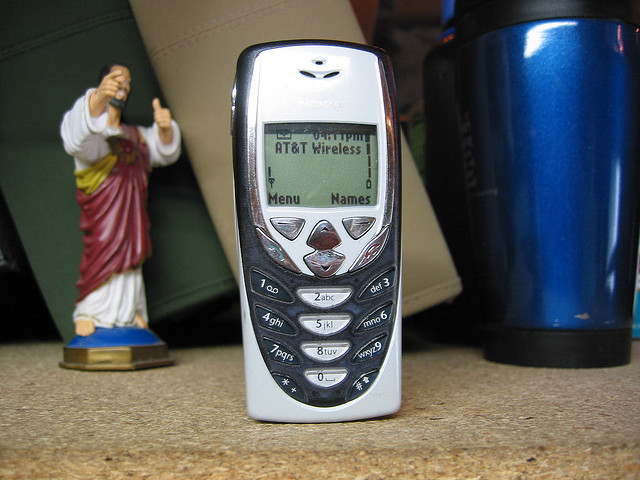

In [79]:
from PIL import Image
Image.open("/Data2/Arun-UAV/NLP/vision_halu/train_datasets/poc_5000_coco_images/COCO_train2014_000000515057.jpg")

"A chat between a curious human and an artificial intelligence assistant. The assistant gives helpful, detailed, and polite answers to the human's questions. USER:  \nPlease describe this image in detail. ASSISTANT:The image presents an indoor, close-up still life scene with soft, diffused lighting, suggesting a casual setting, possibly a desk or shelf. In the foreground, slightly off-center, stands an old-model Nokia mobile phone, predominantly white with silver-gray accents and a black keypad. The phone's screen is illuminated, displaying '04:11PM' at the top right, 'AT&T Wireless' centrally, and 'Menu' and 'Names' at the bottom left and right, respectively. The phone's numeric keypad, featuring white numbers and letters on black buttons, is clearly visible, with a central silver navigation cluster. To the left of the phone, slightly further back in the mid-ground, is a small, colorful figurine of Jesus. He is depicted in white robes with a red sash and a yellow stole, standing on a blue and gold base, with both arms raised and hands giving a thumbs-up gesture, as if in approval or encouragement. Behind the figurine and the phone, the background is softly blurred, revealing muted tones of beige and dark green or brown, possibly indicating other objects or furniture. To the right of the phone, a metallic blue travel mug or thermos with a black base is partially visible, adding another splash of color. The entire arrangement rests on a textured, light brown surface, likely wood or corkboard. The overall atmosphere is one of quirky domesticity, with the juxtaposition of a vintage phone, a religious figurine, and everyday objects creating a unique, almost humorous narrative."

In [87]:
words = """cat
black
white
curled
circle
quilt
blue
striped
patchwork
head
tucked
body
paws
visible
sleep
shades
light
navy
textured
right
teddy
bear
worn
upright
leaning
brown
nose
eyes
string
yarn"""

In [88]:
s_words = words.split("\n")

In [97]:
import re

def count_word_occurrences(text: str, word: str) -> int:
    """
    Counts how many times a given word occurs in a text.

    Args:
        text (str): The input text.
        word (str): The target word to count.

    Returns:
        int: Number of occurrences of the word.
    """
    # \b ensures we match whole words only (not substrings)
    pattern = rf'\b{re.escape(word)}\b'
    matches = re.findall(pattern, text, flags=re.IGNORECASE)
    return len(matches)


In [98]:
text = "'This indoor scene captures a moment of serene slumber, likely in a bedroom or cozy nook, under soft, diffused lighting that suggests either early morning or late afternoon. The main subject is a black and white cat, curled tightly into a perfect circle, nestled comfortably on a blue and white striped patchwork quilt. Its head is tucked into its body, and its white paws are visible, indicating a deep, peaceful sleep. The quilt itself features varying shades of blue, from light sky blue to deeper navy, interspersed with white stripes, creating a calming, textured surface. To the right of the sleeping cat, a soft, light blue teddy bear with a slightly worn appearance sits upright, leaning against a rich, dark red pillow. The teddy bear has a light brown nose and small, dark eyes, and a small, light-colored tuft of string or yarn on its head, giving it a gentle, aged charm. Behind the red pillow, another section of the blue and white quilt is visible. The background reveals a textured, off-white wall, adding to the intimate and comforting atmosphere. The overall mood is one of tranquility, warmth, and domestic comfort, implying a quiet moment of rest for both the beloved pet and the cherished toy, perhaps awaiting the return of their owner or simply enjoying a peaceful afternoon nap.'"

In [99]:
t_sum = 0
for i in s_words:
    t_sum += count_word_occurrences(text, i)

In [100]:
t_sum

50

In [95]:
text = """black
white
cat
led
circle
blue
white
ed
work
ilt
head
ed
body
white
aws
visible
indicating
sleep
ilt
ades
blue
light
blue
avy
white
ured
right
sleep
cat
light
blue
dy
bear
slightly
worn
ight
ing
dy
bear
light
brown
nose
eyes
light
string
arn
head
blue
white
ilt
visible
ured
white"""

In [96]:
len(text.split("\n"))

53

In [107]:
torch.full((575, 576), 0,).shape

torch.Size([575, 576])

In [108]:
import torch

mask1 = torch.tensor([[1, 0, 1],
                      [0, 1, 1]])

mask2 = torch.tensor([[1, 1, 0],
                      [0, 1, 0]])

combined = mask1 * mask2  # element-wise AND
print(combined)

tensor([[1, 0, 0],
        [0, 1, 0]])
